In [ ]:
from tensorflow.python.keras.utils import get_file
import gzip
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras import applications
import cv2
import functools
from keras.models import load_model
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 使用第2个GPU

In [98]:
def load_data():
    paths = [
        'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
        't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz'
    ]

    with gzip.open(paths[0], 'rb') as lbpath:
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[1], 'rb') as imgpath:
        x_train = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28, 1)

    with gzip.open(paths[2], 'rb') as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[3], 'rb') as imgpath:
        x_test = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28, 1)

    return (x_train, y_train), (x_test, y_test)

## 读取数据与数据预处理

In [99]:
 # read dataset
(x_train, y_train), (x_test, y_test) = load_data()
batch_size = 32
epochs = 5
data_augmentation = True  # 图像增强
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models_transfer_learning')
model_name = 'keras_fashion_transfer_learning_trained_model.h5'


# Convert class vectors to binary class matrices.  将类别弄成独热编码
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)


# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# 由于mist的输入数据维度是(num, 28, 28)，vgg16 需要三维图像,因为扩充一下mnist的最后一维
X_train = [cv2.cvtColor(cv2.resize(i, (48, 48)), cv2.COLOR_GRAY2RGB) for i in x_train]
X_test = [cv2.cvtColor(cv2.resize(i, (48, 48)), cv2.COLOR_GRAY2RGB) for i in x_test]

x_train = np.asarray(X_train)
x_test = np.asarray(X_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255  # 归一化
x_test /= 255  # 归一化

## 伪造回归数据
总共有10类衣服，他们每一类的价格设置规则如下：  
以(45, 57, 85, 99, 125, 27, 180, 152, 225, 33)为每一类衣服的均值，以3为标准差，  
利用正太分布小数点后两位的价格作为他们的衣服价格。

In [100]:
# 转成DataFrame格式方便数据处理
y_train_pd = pd.DataFrame(y_train)
y_test_pd = pd.DataFrame(y_test)
# 设置列名
y_train_pd.columns = ['label'] 
y_test_pd.columns = ['label']

# 给每一类衣服设置价格
mean_value_list = [45, 57, 85, 99, 125, 27, 180, 152, 225, 33]  # 均值列表
def setting_clothes_price(row):
    price = sorted(np.random.normal(mean_value_list[int(row)], 3,size=1))[0] #均值mean,标准差std,数量
    return np.round(price, 2)
y_train_pd['price'] = y_train_pd['label'].apply(setting_clothes_price)
y_test_pd['price'] = y_test_pd['label'].apply(setting_clothes_price)

print(y_train_pd.head(5))
print('-------------------')
print(y_test_pd.head(5))

   label  price
0      9  29.66
1      0  45.15
2      0  50.35
3      3  99.19
4      0  46.33
-------------------
   label   price
0      9   32.51
1      2   80.91
2      1   56.77
3      1   56.36
4      6  181.70


## 数据归一化

In [115]:
# y_train_price_pd = y_train_pd['price'].tolist()
# y_test_price_pd = y_test_pd['price'].tolist()
# 训练集归一化
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(y_train_pd)
y_train = min_max_scaler.transform(y_train_pd)[:, 1]

# 验证集归一化
min_max_scaler.fit(y_test_pd)
y_test = min_max_scaler.transform(y_test_pd)[:, 1]
y_test_label = min_max_scaler.transform(y_test_pd)[:, 0]  # 归一化后的标签
print(len(y_train))
print(len(y_test))

60000
10000


## 迁移学习建模

In [102]:
# 使用VGG16模型
base_model = applications.VGG16(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])  # 第一层需要指出图像的大小

# # path to the model weights files.
# top_model_weights_path = 'bottleneck_fc_model.h5'
print(x_train.shape[1:])
model = Sequential()
print(base_model.output)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('linear'))

# add the model on top of the convolutional base
model = Model(inputs=base_model.input, outputs=model(base_model.output))  # VGG16模型与自己构建的模型合并

# 保持VGG16的前15层权值不变，即在训练过程中不训练  
for layer in model.layers[:15]:
    layer.trainable = False

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='mse',
              optimizer=opt,
              )

(48, 48, 3)
Tensor("block5_pool_6/MaxPool:0", shape=(?, 1, 1, 512), dtype=float32)


## 训练

In [103]:
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    print(x_train.shape[0]//batch_size)  # 取整
    print(x_train.shape[0]/batch_size)  # 保留小数
    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,  # 按batch_size大小从x,y生成增强数据
                                     batch_size=batch_size),  
                        # flow_from_directory()从路径生成增强数据,和flow方法相比最大的优点在于不用
                        # 一次将所有的数据读入内存当中,这样减小内存压，这样不会发生OOM
                        epochs=epochs,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        validation_data=(x_test, y_test),
                        workers=10  # 在使用基于进程的线程时，最多需要启动的进程数量。
                       )

Using real-time data augmentation.
1875
1875.0
Epoch 1/5
1875/1875 [==============================] - 1149s 613ms/step - loss: 0.0336 - val_loss: 0.0178
Epoch 2/5
1875/1875 [==============================] - 1805s 963ms/step - loss: 0.0183 - val_loss: 0.0146
Epoch 3/5
1875/1875 [==============================] - 2126s 1s/step - loss: 0.0162 - val_loss: 0.0140
Epoch 4/5
1875/1875 [==============================] - 2279s 1s/step - loss: 0.0151 - val_loss: 0.0145
Epoch 5/5
1875/1875 [==============================] - 2196s 1s/step - loss: 0.0144 - val_loss: 0.0136


## 模型可视化与保存模型

In [104]:
model.summary()
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

## 训练过程可视化

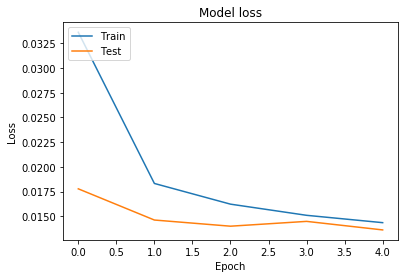

In [106]:
import matplotlib.pyplot as plt
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 模型的预测功能

In [116]:
# 预测
y_new = model.predict(x_test)
# 反归一化
min_max_scaler.fit(y_test_pd)
y_pred_pd = pd.DataFrame({'label':list(y_test_label), 'price':list(y_new)})
y_new = min_max_scaler.inverse_transform(y_pred_pd)

[[  9.          36.39809359]
 [  2.          90.78814453]
 [  1.          58.21489228]
 ...
 [  8.         225.04189952]
 [  1.          58.29625367]
 [  5.         118.09064091]]


## 真实值与预测值

In [120]:
y_test_pd['true_price'] = pd.DataFrame(y_test_pd['price'])
print(y_test_pd.head(20))

    label   price  true_price
0       9   32.51       32.51
1       2   80.91       80.91
2       1   56.77       56.77
3       1   56.36       56.36
4       6  181.70      181.70
5       1   58.06       58.06
6       4  127.31      127.31
7       6  180.50      180.50
8       5   27.21       27.21
9       7  147.69      147.69
10      4  123.40      123.40
11      5   28.70       28.70
12      7  153.20      153.20
13      3   99.74       99.74
14      4  117.12      117.12
15      1   56.82       56.82
16      2   84.18       84.18
17      4  124.43      124.43
18      8  221.80      221.80
19      0   50.01       50.01
